In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ipywidgets as widgets

import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.express as px
from plotly import tools
init_notebook_mode(connected=True)  
import plotly.figure_factory as ff

from tslearn.clustering import TimeSeriesKMeans
from sklearn.linear_model import LinearRegression

import warnings
warnings.simplefilter('ignore')

# Load and Prepare the Data

In [2]:
batting_Lahman = pd.read_csv('./data/Lahman/tables/Batting.csv')
people_Lahman = pd.read_csv('./data/Lahman/tables/People.csv')

In [3]:
batting_people = pd.merge(batting_Lahman, people_Lahman, how='left', left_on='playerID', right_on='playerID')
batting_people['nameFirst'] = batting_people['nameFirst'].astype('str')
batting_people['nameLast'] = batting_people['nameLast'].astype('str')
batting_people['Batters Name'] = batting_people[['nameFirst', 'nameLast']].apply(lambda x: ' '.join(x), axis=1)
batting_people.drop(columns=['nameFirst', 'nameLast', 'nameGiven'], axis=1, inplace=True)

# Scale 2020 Season Data

In 2020, 60 games were played instead of the full 162 games due to the COVID-19 pandemic. Therefore, I scaled the data accordingly.

In [4]:
batting_people_modified = batting_people.copy(deep=True)
batting_people_modified.loc[batting_people_modified.yearID==2020, 'HR'] = batting_people[batting_people.yearID==2020].HR * (162/60)
batting_people_modified.loc[batting_people_modified.yearID==2020, 'R'] = batting_people[batting_people.yearID==2020].R * (162/60)
batting_people_modified.loc[batting_people_modified.yearID==2020, 'AB'] = batting_people[batting_people.yearID==2020].AB * (162/60)
batting_people_modified.loc[batting_people_modified.yearID==2020, 'H'] = batting_people[batting_people.yearID==2020].H * (162/60)
batting_people_modified.loc[batting_people_modified.yearID==2020, '2B'] = batting_people[batting_people.yearID==2020]['2B'] * (162/60)
batting_people_modified.loc[batting_people_modified.yearID==2020, '3B'] = batting_people[batting_people.yearID==2020]['3B'] * (162/60)
batting_people_modified.loc[batting_people_modified.yearID==2020, 'RBI'] = batting_people[batting_people.yearID==2020].RBI * (162/60)

# Taking a Look at the Distribution of the Players with High Total Home Runs

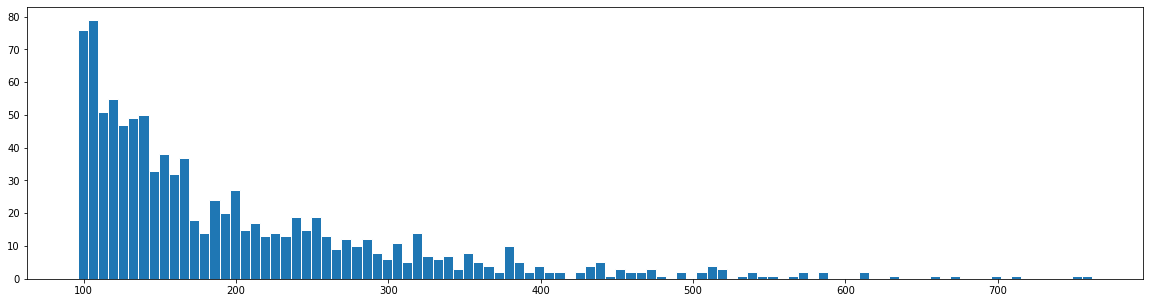

In [5]:
total_HRs = batting_people_modified.groupby(by='playerID').HR.sum().sort_values()
high_total_HRs = total_HRs[total_HRs>total_HRs.quantile(0.95)]

################## Plot high total HR histogram
f, ax = plt.subplots(1, figsize=(20,5))
ax.hist(high_total_HRs, edgecolor='w', bins=100)
plt.show()

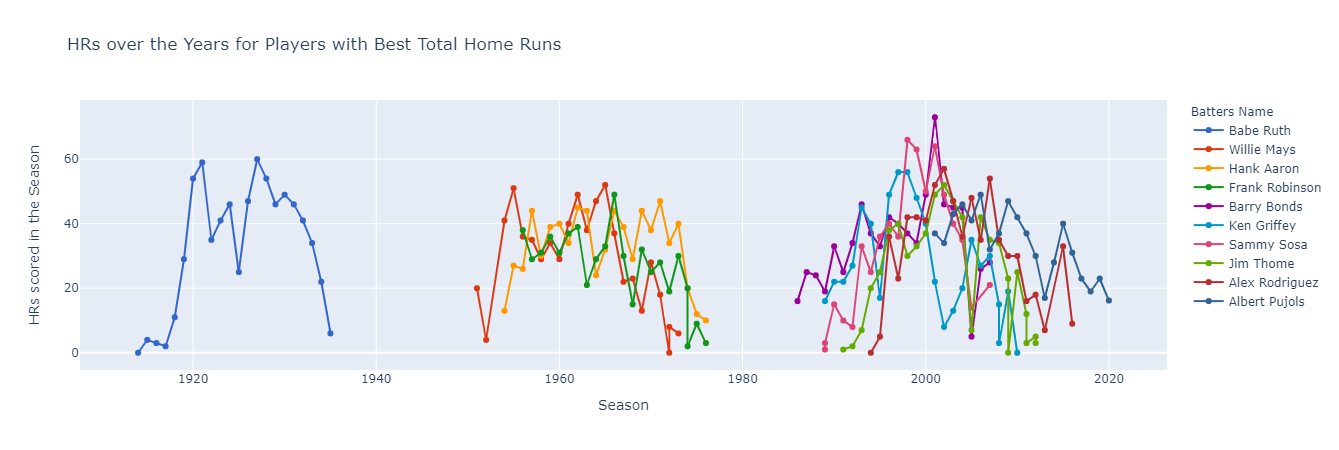

In [6]:
best10_hitterIDs = total_HRs[-10:].index.to_list()[::-1]
best10_df = batting_people_modified[batting_people_modified['playerID'].isin(best10_hitterIDs)]

################ Plotly
fig = px.line(best10_df, x="yearID", y="HR", color="Batters Name", width=1350, height=450,
                 title='HRs over the Years for Players with Best Total Home Runs', color_discrete_sequence=px.colors.qualitative.G10,
                labels={'HR':'HRs scored in the Season', 'yearID':'Season'})
fig.update_traces(mode='markers+lines')
fig.show()

> **The following plot shows the maximum number of home runs has increased over the course of the years. To only consider the data that can be representative of the future, the data from 1950 onwards are included in this analysis.**

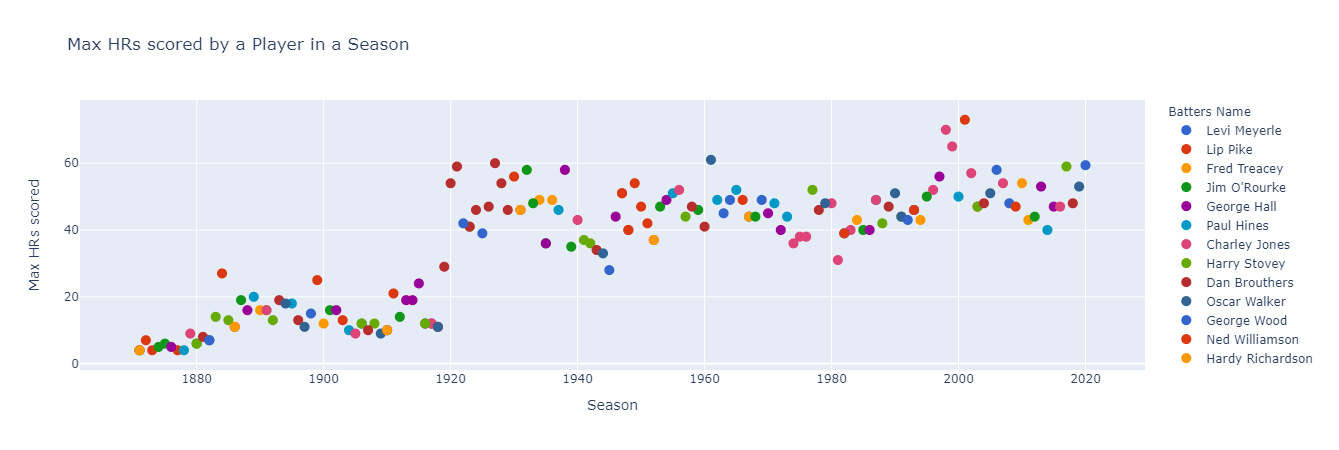

In [7]:
idx = batting_people_modified.groupby('yearID').HR.transform(max) == batting_people_modified.HR
max_HR_df = batting_people_modified[idx]

################ Plotly
fig = px.scatter(max_HR_df, x="yearID", y="HR", color="Batters Name", width=1350, height=450,
                 title='Max HRs scored by a Player in a Season', color_discrete_sequence=px.colors.qualitative.G10,
                labels={'HR':'Max HRs scored', 'yearID':'Season'})
fig.update_traces(marker={'size': 10})
fig.show()

# Keeping Data After 1950

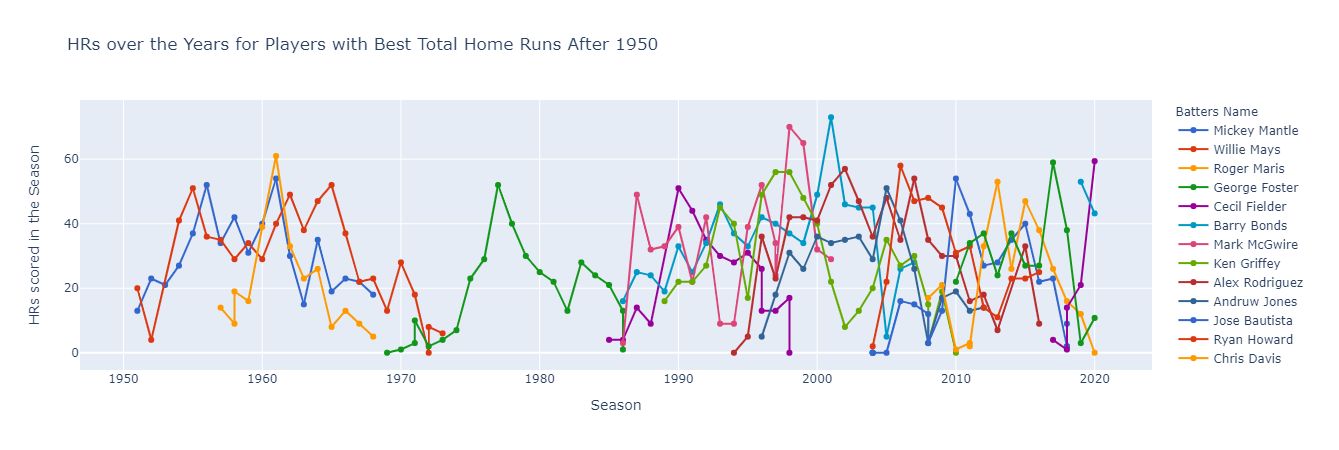

In [8]:
after1950_df = batting_people_modified.groupby(by='playerID').filter(lambda x: x['yearID'].min()>1950)
idx = after1950_df.groupby('yearID').HR.transform(max) == after1950_df.HR
max_HR_df = after1950_df[idx]
tmp = max_HR_df.sort_values(by='HR')[-20:]['playerID'].to_list()
top_HR_batters = list(set(tmp))
plot_df = after1950_df[after1950_df['playerID'].isin(top_HR_batters)]

################ Plotly
fig = px.line(plot_df, x="yearID", y="HR", color="Batters Name", width=1350, height=450,
                 title='HRs over the Years for Players with Best Total Home Runs After 1950', color_discrete_sequence=px.colors.qualitative.G10,
                labels={'HR':'HRs scored in the Season', 'yearID':'Season'})
fig.update_traces(mode='markers+lines')
fig.show()

# Prepare Data for Training the Predictive Model

From the figure above it can be observed that the players reach their maximum number of home runs after playing a few number of years in the MLB. Therefore, I evaluated the players who already played at least 4 years in the MLB and also were present in 2020 season.

## Approach:

First, I separate the data of the successful batters for training a model. The batters who's HR's are among the top in any season are selected for training. Since we do not have the information for the future season, we select the past 4 seasons' data to train a multiple regression (autoregressive) model for prediction of the number of home runs in the next season. Prior to that we cluster the players based on their HR time series over consecutive seasons. We train a different reression model for each cluster. Next, using ab distance metric we assing the new players to one of the clusters and use the corresponding regression to predict the new season's home runs.

In [9]:
# player who played more than 10 seasons
tmp1 = after1950_df.groupby('playerID').apply(lambda x: x.yearID.nunique()>14)
player_ids = tmp1[tmp1].index.to_list()
mareThan14_seasons = after1950_df[after1950_df['playerID'].isin(player_ids)]

# top players by HR mean
tmp2 = mareThan14_seasons.groupby('playerID').HR.mean().sort_values()[-500:].index.to_list()
top_past_players = mareThan14_seasons[mareThan14_seasons['playerID'].isin(tmp2)]

## Cluster the Top Players Based on Their HR Time Series

In [10]:
past_HRs_ts = pd.DataFrame()
nrow = top_past_players.groupby('playerID').HR.count().max()
for g, g_df in top_past_players.groupby('playerID'):#.HR.reset_index()
    past_HRs_ts[g] = g_df['HR'].values[:15]

Ploting all the past home runs time series separately for individual players looks like the plot below. We want to perform clustering to find clusters in which players performed similarly in terms of home runs over the course of seasons.

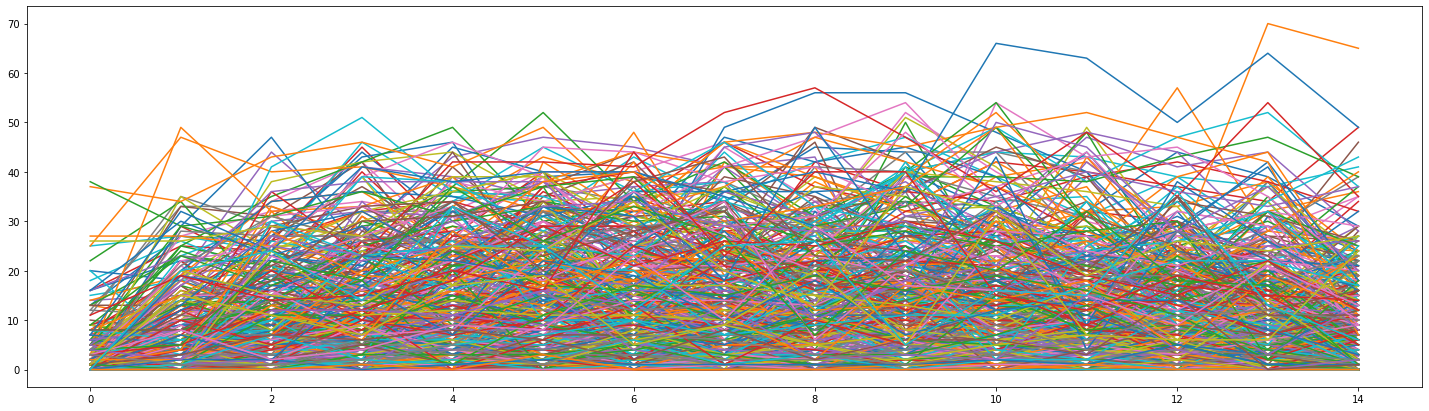

In [11]:
f, ax = plt.subplots(1, figsize=(25, 7))
past_HRs_ts.plot(ax=ax, legend=False)
plt.show()

In [54]:
model = TimeSeriesKMeans(n_clusters=10, metric="euclidean", max_iter=10)
clusters = model.fit_predict(past_HRs_ts.values.T)

cluster_dict = {}
for key in range(np.unique(clusters).shape[0]):
    cluster_dict[key] = past_HRs_ts.iloc[:,list(np.where(clusters==key)[0])]

################## Plot
tabs = np.unique(clusters)
tab_names = ['Cluster ' + str(elem) for elem in tabs]
sub_tab=[widgets.Output() for i in range(len(tabs))]
tab = widgets.Tab(sub_tab)
for i, clust in enumerate(tabs):
    tab.set_title(i,tab_names[i])
    with sub_tab[i]:
        f, ax = plt.subplots(1, figsize=(23,7))
        cluster_dict[clust].plot(ax=ax, legend=False)
        ax.set_ylim([0, 70])
        ax.set_xlabel('Season From Start', fontsize=20)
        ax.set_ylabel('Home Runs', fontsize=20)
        ax.set_title('Players Home Runs in Each Cluster', fontsize=30)
        plt.show()
display(tab)

## Assign Each Batter Who played in 2020 to a Cluster

For prediction, I only included the players who played in 2020 and started at latest in 2017 season.

In [55]:
tmp1 = after1950_df.groupby('playerID').yearID.max()==2020
playerIDs_2020 = tmp1[tmp1].index.to_list()
batters_2020 = after1950_df[after1950_df['playerID'].isin(playerIDs_2020)]

tmp2 = batters_2020.groupby('playerID').yearID.min()<=2017
playerIDs_2017 = tmp2[tmp2].index.to_list()
players_selected = batters_2020[batters_2020['playerID'].isin(playerIDs_2017)]
feature_df = players_selected[['playerID', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'birthYear', 'weight', 'height']].set_index('playerID').astype(float)

## Distance and Assigning to a Cluster
In the following code snippet, for each player who played in 2020 season and also played at least 4 seasons a distance metric calculated against each of the 10 clusters. The distance metric is calculated based on the batting data at the first 4 years of the player's career and his age, weight, and height.

- **Note:** This code snippet may take up to 5 minutes to run.

In [56]:
min_values = top_past_players[['AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'birthYear', 'weight', 'height']].min()
max_values = top_past_players[['AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'birthYear', 'weight', 'height']].max()
dist_df = pd.DataFrame(index=feature_df.index.unique(), columns=np.unique(clusters))

for clust in np.unique(clusters):
    tmp = np.where(clusters==clust)[0]
    cluster_playerIDs = past_HRs_ts.columns[tmp].to_list()
    clust_top_players = top_past_players[top_past_players['playerID'].isin(cluster_playerIDs)]
    clust_features = clust_top_players[['playerID', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'birthYear', 'weight', 'height']].set_index('playerID').astype('float')
    
    for player in feature_df.index.unique():
        new_tmp = feature_df[feature_df.index==player][:4]
        if new_tmp.shape[0]==4:
            new_tmp_norm = (new_tmp - min_values)/max_values
            new_tmp_norm = new_tmp
            tmp_list = []
            for top_player in clust_features.index.unique():
                top_tmp = clust_features[clust_features.index==top_player][:4]
                top_tmp_norm = (top_tmp - min_values)/max_values
                top_tmp_norm = top_tmp
                dist = np.abs(new_tmp_norm.values - top_tmp_norm.values)
                tmp_list.append(np.mean(dist))
            dist_df.at[player, clust] = np.mean(tmp_list)
dist_df = dist_df.dropna()
player_cluster = dist_df.astype('float').idxmin(axis=1)

## Train a Regression Model for Each Cluster
A regression model is trained in each cluster based on the the past 3 years' performance and the player's antropometric data.

In [57]:
mult_reg_dict = {}
for clust in np.unique(clusters):
    playerIDs = cluster_dict[clust].columns.to_list()
    X_list = []; y_list = []
    for idx in playerIDs:
        tmp1 = top_past_players[top_past_players.playerID==idx]
        y = tmp1.HR[3:].values
        y_list.append(y)
        X = np.zeros(shape=(tmp1.shape[0]-3, 21))
        X[:, 0] = tmp1.HR.values[0:-3]
        X[:, 1] = tmp1.HR.values[1:-2]
        X[:, 2] = tmp1.HR.values[2:-1]
        X[:, 3] = tmp1.R.values[0:-3]
        X[:, 4] = tmp1.R.values[1:-2]
        X[:, 5] = tmp1.R.values[2:-1]
        X[:, 6] = tmp1.H.values[0:-3]
        X[:, 7] = tmp1.H.values[1:-2]
        X[:, 8] = tmp1.H.values[2:-1]
        X[:, 9] = tmp1['2B'].values[0:-3]
        X[:, 10] = tmp1['2B'].values[1:-2]
        X[:, 11] = tmp1['2B'].values[2:-1]
        X[:, 12] = tmp1['3B'].values[0:-3]
        X[:, 13] = tmp1['3B'].values[1:-2]
        X[:, 14] = tmp1['3B'].values[2:-1]
        X[:, 15] = tmp1['RBI'].values[0:-3]
        X[:, 16] = tmp1['RBI'].values[1:-2]
        X[:, 17] = tmp1['RBI'].values[2:-1]
        X[:, 18] = tmp1.birthYear.values[0]
        X[:, 19] = tmp1.weight.values[0]
        X[:, 20] = tmp1.height.values[0]
        X_list.append(X)
    X_np = np.concatenate(X_list, axis=0)
    y_np = np.concatenate(y_list, axis=0)

    # Train the multiple regression model
    mult_reg_dict[clust] = LinearRegression().fit(X_np, y_np)

## Make Prediction for each Player

Now every player who played in 2020 season has been assigned to a cluster using the distance metric. Next, we use the cluster's regression model to predict the season's HR's using the batting data from the past 3 seasons and the birth year, weight, and height.

In [58]:
HR_pred_dict = {}
for idx in player_cluster.index:
    tmp1 = players_selected[players_selected.playerID==idx].iloc[-3:,]
    X = np.zeros(shape=(1, 21))
    X[0, 0:3] = tmp1.HR.values
    X[0, 3:6] = tmp1.R.values
    X[0, 6:9] = tmp1.H.values
    X[0, 9:12] = tmp1['2B'].values
    X[0, 12:15] = tmp1['3B'].values
    X[0, 15:18] = tmp1['RBI'].values
    X[0, 18] = tmp1.birthYear.values[0]
    X[0, 19] = tmp1.weight.values[0]
    X[0, 20] = tmp1.height.values[0]
    
    clust = player_cluster[idx]
    HR_pred_dict[idx] = mult_reg_dict[clust].predict(X)[0].astype('int')

In [59]:
max_id = max(HR_pred_dict, key=HR_pred_dict.get)
max_HR = HR_pred_dict[max_id]
max_HR_batter = players_selected[players_selected['playerID']==max_id]['Batters Name'].values[0]

print('Maximum home runs will be scored by {}. \n'.format(max_HR_batter))
print('His home runs are predicted to be: {}'.format(max_HR))

Maximum home runs will be scored by Mike Trout. 

His home runs are predicted to be: 35
